In [2]:
import numpy as np
import camb
import matplotlib.pyplot as plt
from Powerspec import *

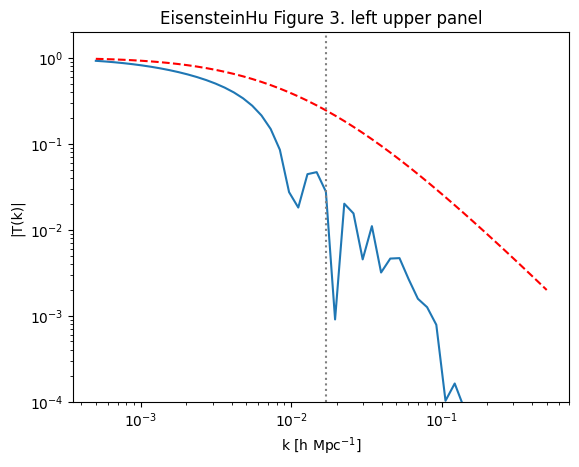

In [2]:
om0h2 = 0.2*0.5**2
ombh2 = om0h2*1
pars = EisensteinHu(ombh2=ombh2, omch2=om0h2-ombh2, h=0.5)
karr = np.logspace(-3,0,50)
p= np.abs(pars.Transfer_function(karr))
loc = pars.first_peak()
q = pars.Transfer_function_zero_baryon(karr)
plt.plot(karr*0.5, p)
plt.plot(karr*0.5, q, linestyle='--', color='red')
plt.axvline(loc*0.5, linestyle=':', color='gray')
plt.ylim(1e-4,2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k [h Mpc$^{-1}$]')
plt.ylabel('|T(k)|')
plt.title('EisensteinHu Figure 3. left upper panel')
plt.savefig('./figs/EH_figure3_left_upper.png', dpi=300)
plt.show()

In [90]:
om0h2 = 0.13348568
ombh2 = 0.02258368
omch2 = om0h2 - ombh2
pars2 =  EisensteinHu(ombh2=ombh2, omch2=omch2, h=0.71, TCMB=2.725)
pars2_params = pars2.print_params()

ombh2: 0.02258368
omch2: 0.110902
omlambh2: 0.6889
omRh2: 0.0
h: 0.71
mnu: 0.0
ns: 0.965
As: 2e-09
tau: 0.0632
TCMB: 2.725


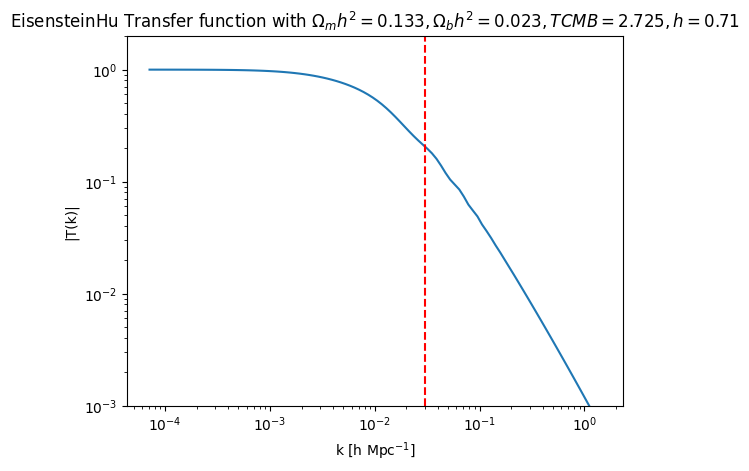

In [111]:

karr = np.logspace(-4,np.log10(2),100)
kharr = karr*pars2.h

p= pars2.Transfer_function(karr)
loc = pars2.first_peak()
plt.plot(kharr, p, label = 'EisensteinHu')
#plt.plot(karr*pars2.h, q, linestyle='--', color='red')
plt.axvline(loc*pars2.h, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} hMpc$^{{-1}}$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,2)
plt.xlabel('k [h Mpc$^{-1}$]')
plt.ylabel('|T(k)|')
plt.title(rf'EisensteinHu Transfer function with $\Omega_mh^2 = {pars2.om0h2:.3f}, \Omega_bh^2 = {pars2.ombh2:.3f}, TCMB = {pars2.TCMB:.3f}, h = {pars2.h:.2f}$')
plt.savefig('./figs/EH_Transfer_CAMB_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

ombh2: 0.0225
omch2: 0.0525
omlambh2: 0.175
omRh2: 0.0
h: 0.5
mnu: 0.0
ns: 0.965
As: 2e-09
tau: 0.0632
TCMB: 2.725
om0h2: 0.075


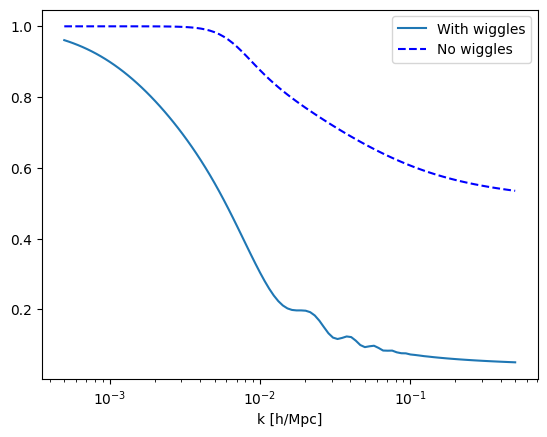

In [6]:
parmtest = {
    'om0h2' : 0.3*0.5**2.,
    'ombh2' : 0.3*0.3*0.5**2.,
    'omch2' : 0.3*0.7*0.5**2.,
    'h' : 0.5,
    'omlambh2' : 0.7*0.5**2.
}
parstest = EisensteinHu(**parmtest)
parstest_parm = parstest.print_params()
karr = np.logspace(-3,0,100)
p = parstest.Transfer_function(karr)
p_nowiggle = parstest.Transfer_function_nowiggles(karr)
p_zero_baryon = parstest.Transfer_function_zero_baryon(karr)
plt.semilogx(karr*parstest.h, p/p_zero_baryon,label='With wiggles')
plt.semilogx(karr*parstest.h, p_nowiggle/p_zero_baryon, label='No wiggles', linestyle='--', color='blue')
plt.xlabel('k [h/Mpc]')
plt.legend()

In [116]:
kharr

array([7.10000000e-05, 7.84698995e-05, 8.67257059e-05, 9.58501046e-05,
       1.05934480e-04, 1.17079831e-04, 1.29397782e-04, 1.43011704e-04,
       1.58057944e-04, 1.74687197e-04, 1.93066011e-04, 2.13378457e-04,
       2.35827973e-04, 2.60639399e-04, 2.88061231e-04, 3.18368111e-04,
       3.51863572e-04, 3.88883087e-04, 4.29797418e-04, 4.75016341e-04,
       5.24992740e-04, 5.80227148e-04, 6.41272760e-04, 7.08740972e-04,
       7.83307504e-04, 8.65719170e-04, 9.56801356e-04, 1.05746628e-03,
       1.16872215e-03, 1.29168324e-03, 1.42758104e-03, 1.57777663e-03,
       1.74377428e-03, 1.92723651e-03, 2.13000077e-03, 2.35409784e-03,
       2.60177212e-03, 2.87550418e-03, 3.17803555e-03, 3.51239620e-03,
       3.88193488e-03, 4.29035267e-03, 4.74174004e-03, 5.24061781e-03,
       5.79198243e-03, 6.40135604e-03, 7.07484176e-03, 7.81918481e-03,
       8.64184008e-03, 9.55104679e-03, 1.05559110e-02, 1.16664968e-02,
       1.28939272e-02, 1.42504954e-02, 1.57497879e-02, 1.74068208e-02,
      

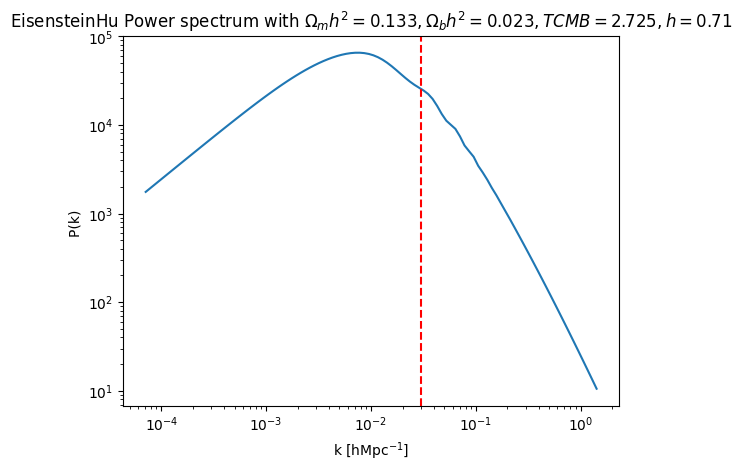

In [97]:
karr2 = np.logspace(-4,np.log10(2),100)
kharr2 = karr2*pars2.h
ps = pars2.Power_spectrum_0(karr2)
plt.loglog(kharr2, ps)
plt.axvline(loc*pars2.h, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} hMpc$^{{-1}}$')
plt.xlabel('k [hMpc$^{-1}$]')
plt.ylabel('P(k) ')
plt.title(rf'EisensteinHu Power spectrum with $\Omega_mh^2 = {pars2.om0h2:.3f}, \Omega_bh^2 = {pars2.ombh2:.3f}, TCMB = {pars2.TCMB:.3f}, h = {pars2.h:.2f}$')
plt.savefig('./figs/EH_Power_spectrum.png', dpi=300, bbox_inches='tight')
plt.show()

/Users/john1256/KASI_Ms/2025/Field_research_2/Powerspec.py:181: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  D1 = 5/2 * self.om0 * H0**2 * Hubble * spi.quad(lambda a: 1/(a*Hubble)**3,0,a)[0] # [6.10]


Rescaling power spectrum... sigma8 = 0.0020660263969862805


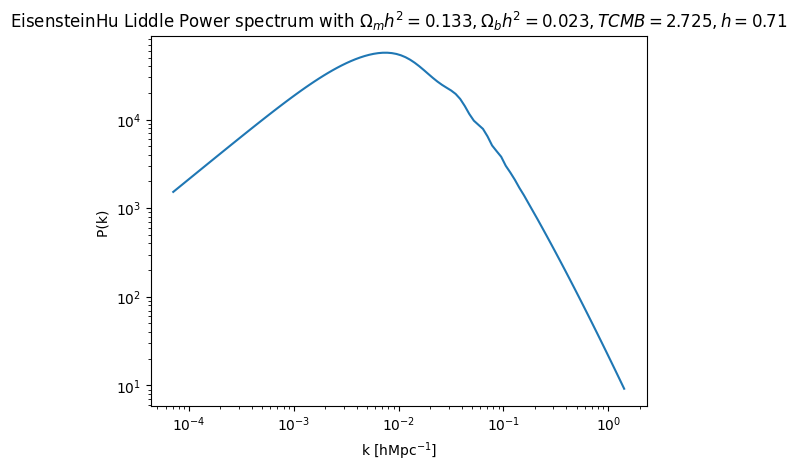

In [98]:
psliddle = pars2.Power_spectrum_liddle(1, karr2, rescale=True)
plt.loglog(kharr2, psliddle)
plt.xlabel('k [hMpc$^{-1}$]')
plt.ylabel('P(k) ')
plt.title(rf'EisensteinHu Liddle Power spectrum with $\Omega_mh^2 = {pars2.om0h2:.3f}, \Omega_bh^2 = {pars2.ombh2:.3f}, TCMB = {pars2.TCMB:.3f}, h = {pars2.h:.2f}$')
plt.savefig('./figs/EH_Power_spectrum_liddle.png', dpi=300, bbox_inches='tight')
plt.show()

In [99]:
pars_CAMB = camb.CAMBparams()
H0 = pars2.h * 100
pars_CAMB.set_cosmology(
    ombh2 = pars2_params['ombh2'],
    omch2 = pars2_params['omch2'],
    H0 = H0,
    TCMB=pars2_params['TCMB'],
    omk=0.0,
    mnu=0.0
)
pars_CAMB.set_dark_energy() #re-set defaults
pars_CAMB.InitPower.set_params(As=pars2.As,ns=pars2.ns)
pars_CAMB.set_matter_power(redshifts=[0], kmax=10)
results = camb.get_results(pars_CAMB)

Text(0.5, 1.0, 'Matter transfer functions from CAMB')

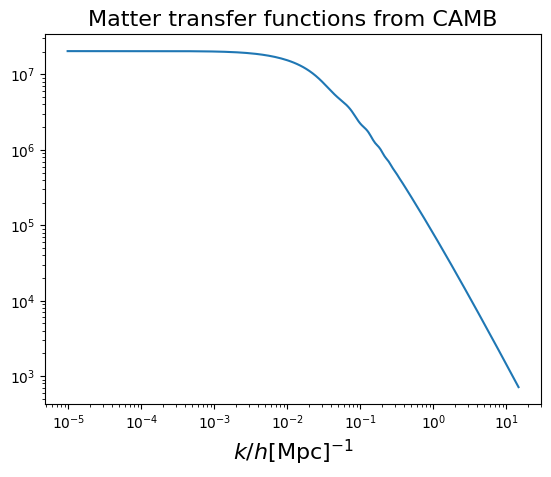

In [104]:
from camb import model

trans = results.get_matter_transfer_data()
kh = trans.transfer_data[0, :, 0]
delta = trans.transfer_data[model.Transfer_tot - 1, :, 0]
plt.loglog(kh, delta)
plt.xlabel(r'$k/h [ \rm Mpc]^{-1}$', fontsize=16)
plt.title('Matter transfer functions from CAMB', fontsize=16)

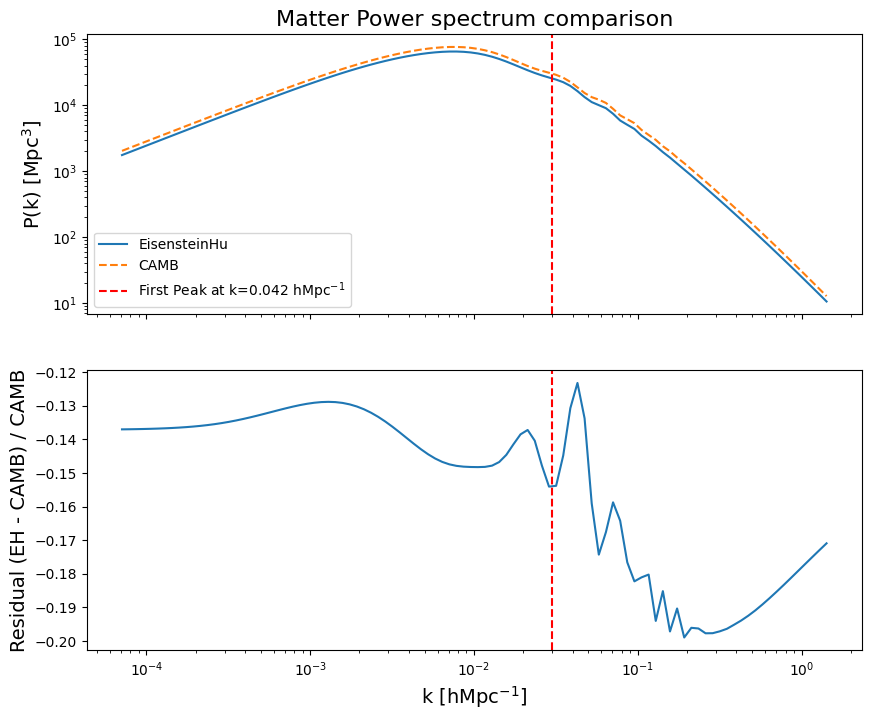

In [108]:
powerspec_camb = results.get_matter_power_interpolator(k_hunit=False, hubble_units=False, nonlinear=False)
pk = powerspec_camb.P(0, karr2)
residual = (ps - pk)/pk
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].loglog(kharr2, ps, label='EisensteinHu')
ax[0].loglog(kharr2, pk, label='CAMB', linestyle='--')
ax[0].axvline(loc*pars2.h, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} hMpc$^{{-1}}$')
ax[0].set_ylabel('P(k) [Mpc$^3$]', fontsize=14)
ax[0].set_title(r'Matter Power spectrum comparison', fontsize=16)
ax[0].legend()
ax[1].semilogx(kharr2, residual)
ax[1].axvline(loc*pars2.h, color='r', linestyle='--', label=f'First Peak at k={loc:.3f} hMpc$^{{-1}}$')
ax[1].set_ylabel('Residual (EH - CAMB) / CAMB', fontsize=14)
ax[1].set_xlabel('k [hMpc$^{-1}$]', fontsize=14)
plt.savefig('./figs/EH_CAMB_Power_spectrum_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


array([7.10000000e-05, 8.16327467e-05, 9.38578215e-05, 1.07913687e-04,
       1.24074516e-04, 1.42655543e-04, 1.64019209e-04, 1.88582233e-04,
       2.16823741e-04, 2.49294613e-04, 2.86628225e-04, 3.29552807e-04,
       3.78905645e-04, 4.35649416e-04, 5.00890964e-04, 5.75902890e-04,
       6.62148376e-04, 7.61309728e-04, 8.75321185e-04, 1.00640666e-03,
       1.15712309e-03, 1.33041037e-03, 1.52964863e-03, 1.75872421e-03,
       2.02210547e-03, 2.32492991e-03, 2.67310442e-03, 3.07342051e-03,
       3.53368673e-03, 4.06288104e-03, 4.67132590e-03, 5.37088963e-03,
       6.17521792e-03, 7.10000000e-03, 8.16327467e-03, 9.38578215e-03,
       1.07913687e-02, 1.24074516e-02, 1.42655543e-02, 1.64019209e-02,
       1.88582233e-02, 2.16823741e-02, 2.49294613e-02, 2.86628225e-02,
       3.29552807e-02, 3.78905645e-02, 4.35649416e-02, 5.00890964e-02,
       5.75902890e-02, 6.62148376e-02, 7.61309728e-02, 8.75321185e-02,
       1.00640666e-01, 1.15712309e-01, 1.33041037e-01, 1.52964863e-01,
      

In [56]:
kh_camb

array([1.00000000e-04, 1.10520985e-04, 1.22148882e-04, 1.35000147e-04,
       1.49203493e-04, 1.64901170e-04, 1.82250398e-04, 2.01424935e-04,
       2.22616822e-04, 2.46038305e-04, 2.71923959e-04, 3.00533038e-04,
       3.32152074e-04, 3.67097745e-04, 4.05720044e-04, 4.48405790e-04,
       4.95582496e-04, 5.47722657e-04, 6.05348477e-04, 6.69037100e-04,
       7.39426394e-04, 8.17221335e-04, 9.03201070e-04, 9.98226721e-04,
       1.10325001e-03, 1.21932277e-03, 1.34760754e-03, 1.48938913e-03,
       1.64608754e-03, 1.81927217e-03, 2.01067752e-03, 2.22222061e-03,
       2.45602011e-03, 2.71441762e-03, 3.00000109e-03, 3.31563076e-03,
       3.66446778e-03, 4.05000589e-03, 4.47610641e-03, 4.94703690e-03,
       5.46751392e-03, 6.04275025e-03, 6.67850710e-03, 7.38115184e-03,
       8.15772173e-03, 9.01599442e-03, 9.96456586e-03, 1.10129364e-02,
       1.21716057e-02, 1.34521786e-02, 1.48674803e-02, 1.64316857e-02,
       1.81604609e-02, 2.00711203e-02, 2.21827999e-02, 2.45166490e-02,
      